In [4]:
import pandas as pd
import numpy as np
import warnings
import seaborn as sns
from lightgbm import LGBMRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

#LightGBM uygulayacağım verisetime eriştim.
df = pd.read_excel("DATASET_LASTFORM.xlsx")

In [5]:
#Tahmin etmek istediğim hedef sütunlar
target_columns = [
    'durationInMs', 'copyDuration', 'durationInQueue', 'queueDuration',
    'transferDuration', 'totalDuration', 'throughput'
]

# X ve y'yi ayırıp, eksik verileri atıyorum.
df = df.dropna(subset=target_columns)
X = df.drop(columns=target_columns)
y = df[target_columns]

#Kategorik ve sayısal sütunlar olarak ayırım
categorical_features = X.select_dtypes(include='object').columns.tolist()
numerical_features = X.select_dtypes(include=['number']).columns.tolist()


In [10]:
# Kategorik sütunların kategorik tipe çevirimi
for col in categorical_features:
    X[col] = X[col].astype('category')

# Eğitim/test bölmesi
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# LightGBM modelini tanımlıyorum.
model = MultiOutputRegressor(
    LGBMRegressor(random_state=42, verbose=-1)
)

# Model eğitimi
model.fit(X_train, y_train, categorical_feature=categorical_features)

# Tahmin
y_pred = model.predict(X_test)


In [11]:
#İlk gözlem için gerçek ve tahmin edilen değerlerin karşılaştırması
rows = []

i = 0  #İlk satır

for col in y.columns:
    rows.append({
        "Sütun": col,
        "Gerçek Değer": round(y_test.iloc[i][col], 2),
        "Tahmin Değeri": round(y_pred[i][y.columns.get_loc(col)], 2)
    })

#Sonuçların bir DataFrame olarak gösterilmesi
comparison_df = pd.DataFrame(rows)

#Sayıları daha okunabilir yapmak için float formatına ayarladım.
pd.options.display.float_format = '{:,.2f}'.format

print("Gerçek vs Tahmin Değerleri (İlk gözlem):")
print(comparison_df)


Gerçek vs Tahmin Değerleri (İlk gözlem):
              Sütun  Gerçek Değer  Tahmin Değeri
0      durationInMs  1,261,651.00   1,326,502.12
1      copyDuration      1,257.00       1,266.59
2   durationInQueue      1,230.00       1,220.67
3     queueDuration      1,229.00       1,227.17
4  transferDuration         20.00          37.09
5     totalDuration      1,257.00       1,277.18
6        throughput        391.25         766.85


In [33]:
#Performans metriklerini her hedef sütun için yazdırıyorum.
print("Her Süre Sütunu İçin LightGBM Performans Skorları:\n")

for i, col in enumerate(y.columns):
    y_true = y_test[col].values
    y_pred_col = y_pred[:, i]  # LightGBM tahminleri

    mse = mean_squared_error(y_true, y_pred_col)
    mae = mean_absolute_error(y_true, y_pred_col)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred_col)
    mean_actual = np.mean(y_true)
    mae_percent = (mae / mean_actual) * 100 if mean_actual != 0 else 0

    print(f"{col}:")
    print(f"  MSE   : {round(mse, 2)}")
    print(f"  MAE   : {round(mae, 2)}")
    print(f"  MAE (%) : {round(mae_percent, 2)}%")
    print(f"  RMSE  : {round(rmse, 2)}")
    print(f"  R²    : {round(r2, 4)}\n")


Her Süre Sütunu İçin LightGBM Performans Skorları:

durationInMs:
  MSE   : 124838323879.29
  MAE   : 163824.85
  MAE (%) : 34.03%
  RMSE  : 353324.67
  R²    : 0.4574

copyDuration:
  MSE   : 6082.26
  MAE   : 18.25
  MAE (%) : 3.33%
  RMSE  : 77.99
  R²    : 0.9745

durationInQueue:
  MSE   : 39.86
  MAE   : 2.55
  MAE (%) : 0.51%
  RMSE  : 6.31
  R²    : 0.9998

queueDuration:
  MSE   : 9.26
  MAE   : 1.52
  MAE (%) : 0.3%
  RMSE  : 3.04
  R²    : 1.0

transferDuration:
  MSE   : 4011.67
  MAE   : 13.55
  MAE (%) : 39.89%
  RMSE  : 63.34
  R²    : 0.6747

totalDuration:
  MSE   : 6254.76
  MAE   : 18.25
  MAE (%) : 3.33%
  RMSE  : 79.09
  R²    : 0.9738

throughput:
  MSE   : 32758.78
  MAE   : 51.53
  MAE (%) : 60.61%
  RMSE  : 180.99
  R²    : 0.7286



In [34]:
#Parametre değerleri
param_grid = {
  'estimator__n_estimators': [50, 100, 150],
  'estimator__learning_rate': [0.01, 0.05, 0.1],
  'estimator__max_depth': [3, 5, 7],
  'estimator__num_leaves': [15, 31, 63]
}

# GridSearchCV ile en iyi parametreleri arıyorum.
model = MultiOutputRegressor(LGBMRegressor(random_state=42, verbose=-1))
grid_search = GridSearchCV(model, param_grid, cv=3, scoring='neg_mean_squared_error', verbose=1)

# Model eğitimi
grid_search.fit(X_train, y_train)

# En iyi parametreler
print("En iyi parametreler:", grid_search.best_params_)

#Optimizasyon için en iyi parametreleri bulmak adına GridSearchCV uyguluyorum.


Fitting 3 folds for each of 81 candidates, totalling 243 fits
En iyi parametreler: {'estimator__learning_rate': 0.1, 'estimator__max_depth': 3, 'estimator__n_estimators': 50, 'estimator__num_leaves': 15}


In [35]:
# Hyperopt bu fonksiyonu çağırarak farklı parametre kombinasyonlarını dener.
def objective(params):
    model = LGBMRegressor(
        n_estimators=int(params['n_estimators']),
        learning_rate=params['learning_rate'],
        max_depth=int(params['max_depth']),
        num_leaves=int(params['num_leaves']),
        random_state=42,
        verbose=-1
    )

    # 3 katlı çapraz doğrulama
    score = cross_val_score(model, X_train, y_train['totalDuration'], cv=3, scoring='neg_mean_squared_error').mean()

    # Hyperopt minimumu aradığı için negatif skor döndürülür
    return {'loss': -score, 'status': STATUS_OK}

#Hiperparametrelerin aranacağı alan
space = {
    'n_estimators': hp.quniform('n_estimators', 50, 150, 25),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.1),
    'max_depth': hp.quniform('max_depth', 3, 6, 1),
    'num_leaves': hp.quniform('num_leaves', 15, 50, 5)
}

# En iyi parametreleri bulmak için optimizasyonu başlatıyorum.
trials = Trials()
best = fmin(
    fn=objective,
    space=space,
    algo=tpe.suggest,  # Bayes optimizasyon algoritması
    max_evals=30,
    trials=trials,
    rstate=np.random.default_rng(42)
)

# Hyperopt çıktısı float64 türünde geldi, bunları daha okunabilir hale getirmek için dönüştürüyorum.
best_converted = {
    'n_estimators': int(best['n_estimators']),
    'learning_rate': float(best['learning_rate']),
    'max_depth': int(best['max_depth']),
    'num_leaves': int(best['num_leaves'])
}

print("En iyi parametreler:", best_converted)

#Hyperopt ile en iyi parametreleri bulmak üzere optimizasyon uyguladım.

100%|██████████| 30/30 [00:05<00:00,  5.15trial/s, best loss: 2521.0368247457864]
En iyi parametreler: {'n_estimators': 150, 'learning_rate': 0.09994366672829999, 'max_depth': 3, 'num_leaves': 20}


In [38]:
#Uyarıları kapattım.
warnings.filterwarnings('ignore', category=FutureWarning)

# En iyi parametreleri buraya koyuyorum.
best_params = {
    'n_estimators': 150,
    'learning_rate':  0.09994366672829999,
    'max_depth': 3,
    'num_leaves':  20
}

# Modeli oluşturuyorum.
lgbm = LGBMRegressor(
    n_estimators=best_params['n_estimators'],
    learning_rate=best_params['learning_rate'],
    max_depth=best_params['max_depth'],
    num_leaves=best_params['num_leaves'],
    random_state=42,
    verbose=-1
)

multi_lgbm = MultiOutputRegressor(lgbm)

# Pipeline oluşturuyorum
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numerical_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
])

pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('regressor', multi_lgbm)
])

# Model eğitimi
pipeline.fit(X_train, y_train)

# Tahmin
y_pred = pipeline.predict(X_test)

# Yeni parametrelere göre performans metriklerini hesaplıyorum.
print("Her Süre Sütunu İçin Performans Skorları:\n")

for i, col in enumerate(y_train.columns):
    y_true = y_test[col].values
    y_pred_col = y_pred[:, i]

    mse = mean_squared_error(y_true, y_pred_col)
    mae = mean_absolute_error(y_true, y_pred_col)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred_col)
    mean_actual = np.mean(y_true)
    mae_percent = (mae / mean_actual) * 100 if mean_actual != 0 else 0

    print(f"{col}:")
    print(f"  MSE     : {round(mse, 2)}")
    print(f"  MAE     : {round(mae, 2)}")
    print(f"  MAE (%) : {round(mae_percent, 2)}%")
    print(f"  RMSE    : {round(rmse, 2)}")
    print(f"  R²      : {round(r2, 4)}\n")

#Hyperopt ile bulduğum en iyi parametreleri bu kısımda yerine koyuyorum ve metrikleri iyileştiriyorum.

Her Süre Sütunu İçin Performans Skorları:

durationInMs:
  MSE     : 90206450371.65
  MAE     : 145382.12
  MAE (%) : 30.2%
  RMSE    : 300343.89
  R²      : 0.6079

copyDuration:
  MSE     : 6041.96
  MAE     : 21.62
  MAE (%) : 3.95%
  RMSE    : 77.73
  R²      : 0.9747

durationInQueue:
  MSE     : 39.06
  MAE     : 3.06
  MAE (%) : 0.61%
  RMSE    : 6.25
  R²      : 0.9998

queueDuration:
  MSE     : 13.03
  MAE     : 2.07
  MAE (%) : 0.41%
  RMSE    : 3.61
  R²      : 0.9999

transferDuration:
  MSE     : 4092.48
  MAE     : 15.64
  MAE (%) : 46.04%
  RMSE    : 63.97
  R²      : 0.6681

totalDuration:
  MSE     : 6263.15
  MAE     : 21.02
  MAE (%) : 3.84%
  RMSE    : 79.14
  R²      : 0.9738

throughput:
  MSE     : 31179.26
  MAE     : 53.39
  MAE (%) : 62.79%
  RMSE    : 176.58
  R²      : 0.7417



In [27]:
#İlk gözlem için gerçek ve tahmin edilen değerlerin karşılaştırması
rows = []

i = 0  #İlk satır

for col in y.columns:
    rows.append({
        "Sütun": col,
        "Gerçek Değer": round(y_test.iloc[i][col], 2),
        "Tahmin Değeri": round(y_pred[i][y.columns.get_loc(col)], 2)
    })

#Sonuçların bir DataFrame olarak gösterilmesi
comparison_df = pd.DataFrame(rows)

#Sayıları daha okunabilir yapmak için float formatına ayarladım.
pd.options.display.float_format = '{:,.2f}'.format

print("Gerçek vs Tahmin Değerleri (İlk gözlem):")
print(comparison_df)

Gerçek vs Tahmin Değerleri (İlk gözlem):
              Sütun  Gerçek Değer  Tahmin Değeri
0      durationInMs  1,261,651.00   1,297,700.95
1      copyDuration      1,257.00       1,274.57
2   durationInQueue      1,230.00       1,219.71
3     queueDuration      1,229.00       1,227.24
4  transferDuration         20.00          54.24
5     totalDuration      1,257.00       1,270.48
6        throughput        391.25         785.19


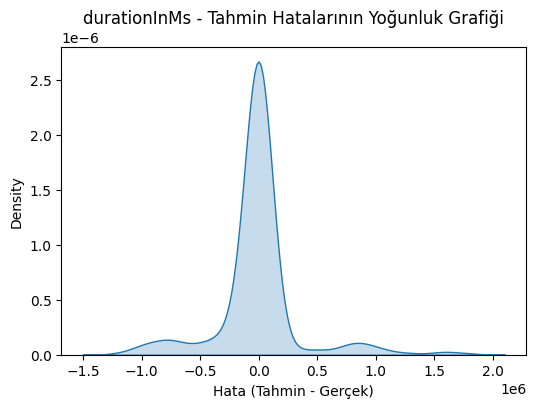

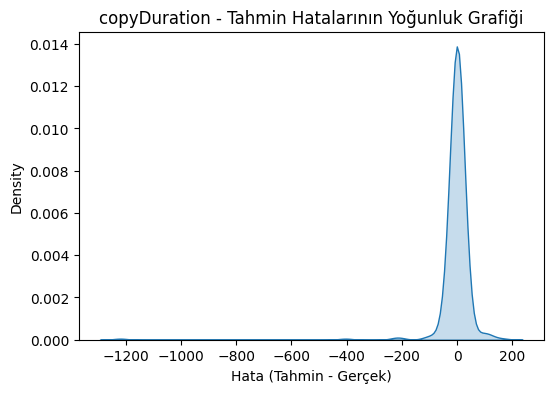

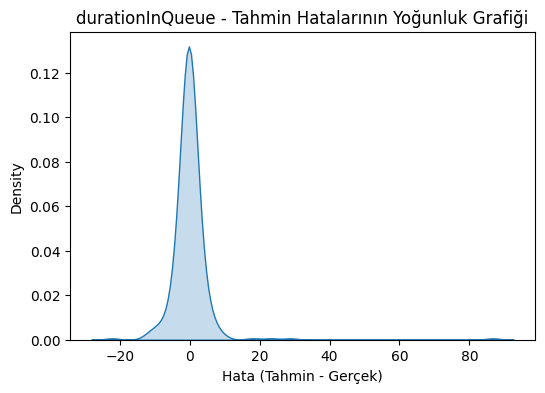

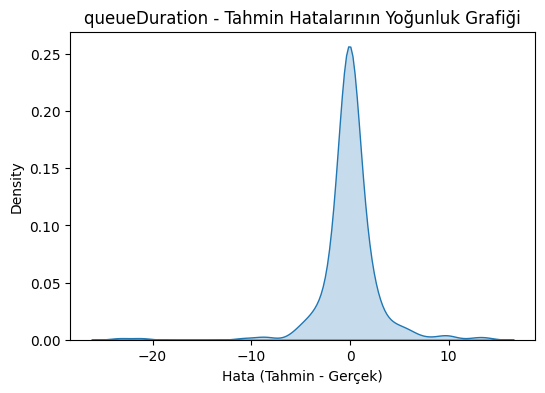

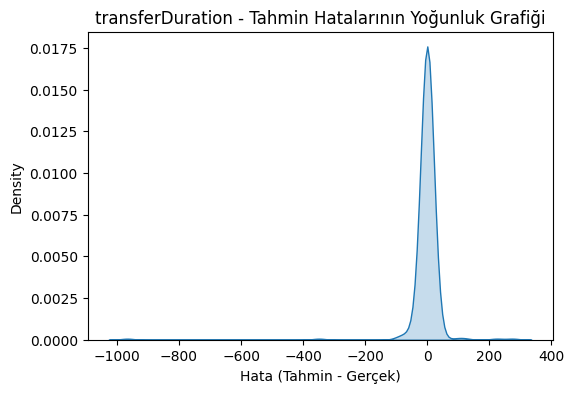

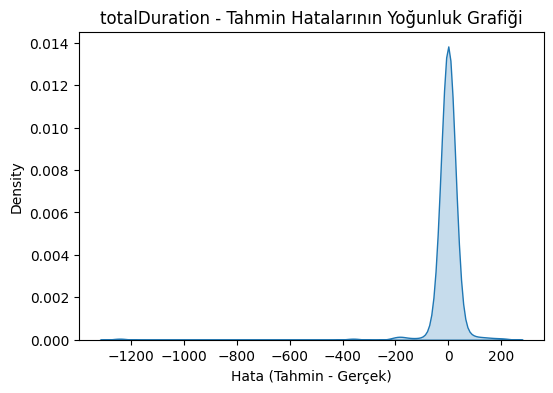

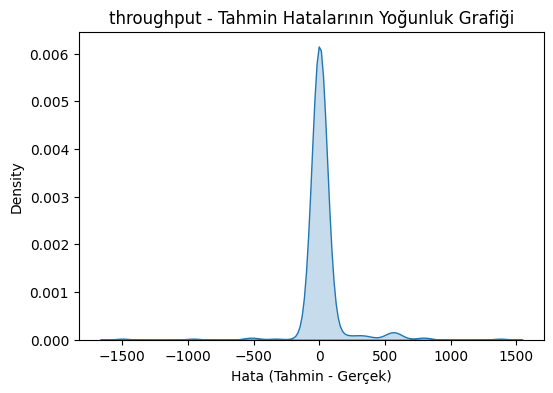

In [32]:
#Her hedef sütun için tahmin hatalarının dağılımını KDE grafiği ile görselleştirdim.
for i, col in enumerate(y_train.columns):
    y_true = y_test[col].values
    y_pred_col = y_pred[:, i]
    errors = y_pred_col - y_true

    plt.figure(figsize=(6, 4))
    sns.kdeplot(errors, shade=True)
    plt.title(f'{col} - Tahmin Hatalarının Yoğunluk Grafiği')
    plt.xlabel('Hata (Tahmin - Gerçek)')
    plt.show()
